# Environment set up

In this section we will set up a Colab environment for the MLEnd mini-project. Before starting, follow these simple instructions: 

1.   Go to https://drive.google.com/
2.   Create a folder named 'Data' in 'MyDrive'. On the left, click 'New' > 'Folder', enter the name 'Data', and click 'create'
3.   Open the 'Data' folder and create a folder named 'MLEnd'.
4.   Move the file 'trainingMLEnd.csv' to the newly created folder 'MyDrive/Data/MLEnd'.



In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Run the following cell to check that the MLEnd folder contains the file 'trainingMLEnd,csv':

In [ ]:
path = '/content/drive/MyDrive/Data/MLEnd'
os.listdir(path)

['trainingMLEnd.csv', 'training.zip', 'training']

# Data download

In this section we will download the data that you need to build your solutions. Note that even though we call it "training" dataset you can do whatever you want with it, for instance validation tasks. Note that we keep a separate dataset for testing purposes, which we won't share with anyone.

First, we will define a function that will allow us to download a file into a chosen location.

In [ ]:
#def download_url(url, save_path):
#    with urllib.request.urlopen(url) as dl_file:
#        with open(save_path, 'wb') as out_file:
#            out_file.write(dl_file.read())

The next step is to download the file 'training.zip' into the folder 'MyDrive/Data/MLEnd'. Note that this might take a while.

In [ ]:
#url  = "https://collect.qmul.ac.uk/down?t=6H8231DQL1NGDI9A/613DLM2R3OFV5EEH9INK2OG"
#save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
#download_url(url, save_path)

Finally, let's unzip the training file.

In [ ]:
#directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
#with zipfile.ZipFile(save_path, 'r') as zip_ref:
#    zip_ref.extractall(directory_to_extract_to)

Once this step is completed, you should have all the audio files in the location 'MyDrive/Data/MLEnd/training/training'. 

# Understanding our dataset

Let's check how many audio files we have in our training dataset:

In [ ]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

This figure (20k) corresponds to the number of **items** or **samples** in our dataset. Let's listen to some random audio files:

In [ ]:
# five random files
for _ in range(5):
    n = np.random.randint(20000)
    display(ipd.Audio(files[n]))

Can you recognise the numeral and intonation? Can you recognise the speaker?

Let's now load the contents of 'trainingMLEnd.csv' into a pandas DataFrame and explore them:

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


This file consists of 20k rows and 4 columns. Each row corresponds to one of the items in our dataset, and each item is described by four attributes:


1.   File ID (audio file)
2.   Numeral
3.   Participand ID
4.   Intonation

Could you explore this dataset further and identify how many items we have per numeral, per individual and per intonation?

In [ ]:
labels['digit_label']

0         4
1         2
2        70
3         2
4         4
         ..
19995    90
19996    10
19997    90
19998    19
19999    20
Name: digit_label, Length: 20000, dtype: int64

In [ ]:
np.sort(labels['digit_label'].unique())


array([         0,          1,          2,          3,          4,
                5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,
               15,         16,         17,         18,         19,
               20,         30,         40,         50,         60,
               70,         80,         90,        100,       1000,
          1000000, 1000000000])

In [ ]:
labels['digit_label'].value_counts()

6             668
1             663
9             663
0             655
8             653
2             652
3             650
5             650
4             641
30            640
14            639
7             638
70            638
100           625
18            625
1000000       623
20            622
15            620
40            618
1000000000    618
60            617
17            614
10            609
50            606
80            605
1000          604
12            601
13            598
11            596
90            595
19            585
16            569
Name: digit_label, dtype: int64

In [ ]:
labels['File ID'].value_counts(sort=True, ascending=False)

0005525.wav    1
0009002.wav    1
0014317.wav    1
0018782.wav    1
0004425.wav    1
              ..
0008825.wav    1
0017311.wav    1
0012092.wav    1
0017925.wav    1
0001211.wav    1
Name: File ID, Length: 20000, dtype: int64

In [ ]:
labels['intonation'].value_counts()

bored       5000
excited     5000
question    5000
neutral     5000
Name: intonation, dtype: int64

In [ ]:
labels['intonation'].unique()

array(['question', 'excited', 'neutral', 'bored'], dtype=object)

In [ ]:
intonation_labels = labels['intonation'].unique()

# Feature extraction : Picth

Audio files are complex data types. Specifically they are **discrete signals** or **time series**, consisting of values on a 1D grid. These values are known as *samples* themselves, which might be a bit confusing, as we have used this term to refer to the *items* in our dataset. The **sampling frequency** is the rate at which samples in an audio file are produced. For instance a sampling frequency of 5HZ indicates that 5 produce 5 samples per second, or 1 sample every 0.2 s.

Let's plot one of our audio signals:

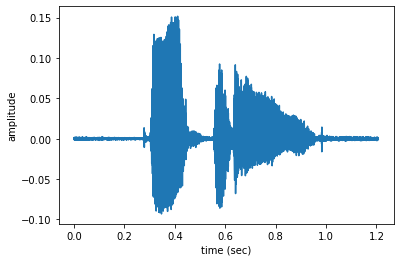

In [ ]:
n=106
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=fs)[0]
spectral_centroids.shape

(53,)

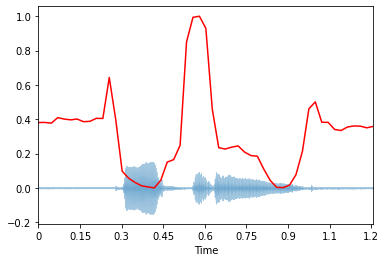

In [ ]:
import librosa.display
import sklearn

# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=fs, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

The file that we are listening to is:

In [ ]:
files[n]

'/content/drive/MyDrive/Data/MLEnd/training/Training/0001158.wav'

In [ ]:
labels.loc[labels['File ID']=='0001158.wav']

,File ID,digit_label,participant,intonation
1158,0001158.wav,13,S8,bored


Can you recognise the numeral and intonation? Compare them with the values for the numeral and intonation that you can find in the `labels` DataFrame. By changing the value of `n` in the previous cell, you can listen to other examples. If you are doing this during one of our lab sessions, please make sure that your mic is muted!

Exactly, how complex is an audio signal? Let's start by looking at the number of samples in one of our audio files:

In [ ]:
n=0
x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 26880 samples


If we are using a raw audio signal as a predictor, we will be operating in a predictor space consisting of tens of thousands of dimensions. Compare this figure with the number of samples that we have. Do we have enough samples to train a model that takes one of these audio signals as an input?

One approach is to extract a few features from our signals and use these features instead as predictors. In the following cell, we define a function that extracts four features from an audio signal, namely:


1.   Power.
2.   Pitch mean.
3.   Pitch standard deviation.
4.   Fraction of voiced region.

In the next cell, we define a new function that gets the pitch of an audio signal.

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
    p = winLen*fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs, frame_length=frame_length,hop_length=hop_length)
    return f0,voiced_flag

Let's now consider the problem of identifying a numeral between 0 and 9. Then next cell defines a function that takes a number of files and creates a NumPy array containing the 4 audio features used as predictors (`X`) and their labels (`y`). 

In [ ]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
    X,y =[],[]
    for file in tqdm(files):
        fileID = file.split('/')[-1]
        yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
        label = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
        if onlySingleDigit and yi>9:
            continue
        else:
            fs = None # if None, fs would be 22050
            x, fs = librosa.load(file,sr=fs)
            if scale_audio: x = x/np.max(np.abs(x))
            f0, voiced_flag = getPitch(x,fs,winLen=0.02)

            power = np.sum(x**2)/len(x)
            pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
            pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
            voiced_fr = np.mean(voiced_flag)

            xi = [power,pitch_mean,pitch_std,voiced_fr]
            X.append(xi)
            y.append(label)
    return np.array(X),np.array(y)

Let's apply `getXy` to the first 500 files. Note that the first 500 files contains numerals outside the [0, 9] range, which we wil be discaarding.

In [ ]:
X,y = getXy(files[:2000],labels_file=labels,scale_audio=True, onlySingleDigit=True)

# If you want to use all 20000 files, run next line instead
#X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)

100%|██████████| 2000/2000 [03:06<00:00, 10.72it/s]


In [ ]:
a,b = getXy(files[:500],labels_file=labels,scale_audio=True, onlySingleDigit=True)


100%|██████████| 500/500 [00:46<00:00, 10.75it/s]


In [ ]:
c,d = getXy(files[:5000],labels_file=labels,scale_audio=True, onlySingleDigit=True)

# If you want to use all 20000 files, run next line instead
#X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)

100%|██████████| 5000/5000 [18:37<00:00,  4.48it/s]


The next cell shows the shape of `X` and `y` and prints the labels vector `y`:

In [ ]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (629, 4)
The shape of y is (629,)
The labels vector is ['question' 'excited' 'question' 'neutral' 'bored' 'bored' 'question'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'bored'
 'question' 'neutral' 'bored' 'neutral' 'excited' 'excited' 'excited'
 'bored' 'bored' 'neutral' 'question' 'question' 'neutral' 'neutral'
 'bored' 'question' 'neutral' 'bored' 'question' 'bored' 'bored' 'neutral'
 'neutral' 'question' 'excited' 'excited' 'neutral' 'bored' 'excited'
 'neutral' 'excited' 'bored' 'bored' 'question' 'excited' 'neutral'
 'question' 'question' 'question' 'question' 'excited' 'bored' 'bored'
 'excited' 'excited' 'neutral' 'bored' 'question' 'bored' 'excited'
 'question' 'neutral' 'question' 'question' 'question' 'neutral' 'excited'
 'question' 'bored' 'bored' 'question' 'bored' 'bored' 'excited' 'bored'
 'neutral' 'neutral' 'excited' 'excited' 'neutral' 'bored' 'bored'
 'excited' 'neutral' 'bored' 'question' 'excited' 'neutral' 'neutral'
 'question' 

In [ ]:
unique, counts = np.unique(d, return_counts=True)
dict(zip(unique, counts))

{'bored': 433, 'excited': 408, 'neutral': 400, 'question': 394}

Finally, to be on the cautious side, let's eliminate any potential item with a NaN (*not a number*).

In [ ]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
    idx = np.isnan(X).sum(1)>0
    X = X[~idx]
    y = y[~idx]
print(np.sum(np.isnan(X)))

0


# Modeling: Support Vector Machines

Let's build a support vector machine (SVM) model for the predictive task of identifying digits in an audio signal, using the dataset that we have just created.

We will use the SVM method provided by `scikit-learn` and will split the dataset defined by `X` and `y` into a training set and a validation set.

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(a,b,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((109, 4), (48, 4), (109,), (48,))

Can you identify the number of items in the training and validation sets?

Let's now fit an SVM model and print both the training accuracty and validation accuracy.

In [ ]:
model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.45871559633027525
Validation  Accuracy 0.3333333333333333


Compare the training and validation accuracies. What do you observe? What do you think the accuracy of a random classifier would be?

Let's normalise the predictors, to see if the performance improves.

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(a,b,test_size=0.2)


mean = X_train.mean(0)
sd =  X_train.std(0)


X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC(C=1, gamma=2)
model.fit(X_train,y_train)


yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.832
Validation  Accuracy 0.40625


Once again, compare the training and validation accuracies. Do you think this classifier is better than the previous one? What could you do to build a better classifier?

In [ ]:
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(a,b,test_size=0.2)

model = SVC( C=1, gamma=2, kernel='rbf')

mean = X_train.mean(0)
sd =  X_train.std(0)
X_train = (X_train-mean)/sd

mean = X_val.mean(0)
sd =  X_val.std(0)
X_val  = (X_val-mean)/sd

model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)


print(f'SVC Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'SVC Model\'s accuracy on validation set is {100*model.score(X_val, y_val):.2f}%')

SVC Model's accuracy on training set is 82.40%
SVC Model's accuracy on validation set is 43.75%


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(c, d, test_size=0.2, stratify=d)

model = SVC( C=8, gamma=0.2, kernel='rbf', random_state=42)

mean = X_train.mean(0)
sd =  X_train.std(0)
X_train = (X_train-mean)/sd

mean = X_val.mean(0)
sd =  X_val.std(0)
X_val  = (X_val-mean)/sd

#model  = svm.SVC(C=1,gamma=2)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)


print(f'SVC Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'SVC Model\'s accuracy on validation set is {100*model.score(X_val, y_val):.2f}%')

SVC Model's accuracy on training set is 58.56%
SVC Model's accuracy on validation set is 51.07%


In [ ]:
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{'bored': 87, 'excited': 81, 'neutral': 80, 'question': 79}

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{'bored': 122, 'excited': 104, 'neutral': 113, 'question': 101}

### Comparing Models

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3,stratify=y)
#X_train, X_val, y_train, y_val = train_test_split(a,b,test_size=0.3,stratify=b)
X_train, X_val, y_train, y_val = train_test_split(c,d,test_size=0.2,stratify=d)


mean = X_train.mean(0)
sd =  X_train.std(0)
X_train = (X_train-mean)/sd

mean = X_val.mean(0)
sd =  X_val.std(0)
X_val  = (X_val-mean)/sd

classification_models = [
    KNeighborsClassifier(),#(3),
    #SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train, y_train)
    score = model.score(X_val, y_val)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
    
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score
3,RandomForestClassifier,48.93%
1,SVC RBF kernel,48.62%
5,GaussianNB,47.71%
6,QuadraticDiscriminantAnalysis,46.18%
4,AdaBoostClassifier,45.87%
0,KNeighborsClassifier,42.20%
2,DecisionTreeClassifier,41.28%


#### SVM GridSearchCV


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

X_train, X_val, y_train, y_val = train_test_split(c,d,test_size=0.2,stratify=d)

mean = X_train.mean(0)
sd =  X_train.std(0)
X_train = (X_train-mean)/sd

mean = X_val.mean(0)
sd =  X_val.std(0)
X_val  = (X_val-mean)/sd

param_grid = { 'C':[1,2,3,4,5,6,7,8,9,10,11,12],'kernel':['rbf'],'gamma': [2, 1, 0.1, 0.2, 0.3, 0.4, 0.5 , 0.6, 0.7]}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


grid_predictions = grid.predict(X_val)
print(confusion_matrix(y_val,grid_predictions))
print(classification_report(y_val,grid_predictions))#Output


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] C=1, gamma=2, kernel=rbf ........................................
[CV] ......................... C=1, gamma=2, kernel=rbf, total=   0.1s
[CV] C=1, gamma=2, kernel=rbf ........................................
[CV] ......................... C=1, gamma=2, kernel=rbf, total=   0.1s
[CV] C=1, gamma=2, kernel=rbf ........................................
[CV] ......................... C=1, gamma=2, kernel=rbf, total=   0.1s
[CV] C=1, gamma=2, kernel=rbf ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ......................... C=1, gamma=2, kernel=rbf, total=   0.1s
[CV] C=1, gamma=2, kernel=rbf ........................................
[CV] ......................... C=1, gamma=2, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:   34.4s finished


#### KNeighborsClassifier GridSearchCV


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

#X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(a,b,test_size=0.3)

mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd


k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
leaf_size = list(range(1,50))

param_grid = dict(leaf_size=leaf_size, n_neighbors = k_range, weights = weight_options)
#print (param_grid)
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy')
grid.fit(X_train,y_train)

#print(grid.grid_scores_)
'''
print(grid.grid_scores_[0].parameters)
print(grid.grid_scores_[0].cv_validation_scores)
print(grid.grid_scores_[0].mean_validation_score)
'''

print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)
print('Test dataset accuracy of best hyperparameter setting: {0}.'.format(grid.score(X_val, y_val)))

0.5609090909090908
{'leaf_size': 1, 'n_neighbors': 17, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='uniform')
Test dataset accuracy of best hyperparameter setting: 0.3541666666666667.


#### RandomForestClassifier GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


#X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(a,b,test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(c,d,test_size=0.3,stratify=d)


mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd


rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [ 6000,8000],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
grid.fit(X_train, y_train)


print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)
print('Test dataset accuracy (random forest classifier): {0}.'.format(grid.score(X_val, y_val)))

0.5140082739600093
{'max_features': 'auto', 'n_estimators': 8000}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=8000,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)
Test dataset accuracy (random forest classifier): 0.5315682281059063.


### Preprocessing 

In [ ]:
def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0) 
    return mfc_coefficients

def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)
        feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))
        return feature_matrix

In [ ]:
features = get_features(file)

NameError: ignored

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features 
features_scaled = scaler.fit_transform(features_scaled)



NameError: ignored